# Word2Vec

사람이 사용하는 단어를 컴퓨터가 처리할 수 있도록 특정 차원의 벡터로 만들어 주는 word embedding의 대표적인 방법.

## One-Hot Vector, One-Hot Encoding

We    = [1, 0, 0, 0, 0]

are   = [0, 1, 0, 0, 0]

about = [0, 0, 1, 0, 0]

to    = [0, 0, 0, 1, 0]

study = [0, 0, 0, 0, 1]

벡터의 하나의 원소만 '1'이고, 나머지는 모두 '0'

단어들간 유사도를 나타낼 수 없음.
문장 데이터가 많아 질수록, 사전의 크기가 커짐 >> 모델이 느려지고, 비효율적임.


## Distributed Representation (분산 표현)

One-Hot encoding은 sparse representaion (희소 표현)

#### 분산표현은 다차원 공간에 벡터화를 통해서 비슷한 위치에서 등장하는 단어들은 비슷한 의미를 가지도록 함.

단어의 개수 10000개,

만약 people의 인덱스가 4라면 희소표현에서는 10000개 중에 하나의 원소만 '1' 나머지는 '0'

ex) people = [0, 0, 0, 0, 1, 0, 0, ..., 0]



분산 표현에서는 실수 하나의 값만 바뀌어도 다른 단어로 인식할 수 있음. 즉, 10000개 보다 작은 100, 150, 300차원 등의 비교적 작은 크기의 벡터로 표현 할 수 있고, 단어를 여러차원에 분산하여 표현하기 때문에, 단어 간 유사도를 계산할 수 있음.

ex) people = [0.2, 0.5, 0.1, 0.2 ..., 0.6]

![python image2](https://shuuki4.files.wordpress.com/2016/01/vector.png)

#### A word2vec embedding of tokens from C/C++ source code
(https://www.researchgate.net/figure/A-word2vec-embedding-of-tokens-from-C-C-source-code_fig3_328074198)
![python image2](https://www.researchgate.net/profile/Erik_Antelman/publication/328074198/figure/fig3/AS:678016141234185@1538663053762/A-word2vec-embedding-of-tokens-from-C-C-source-code.png)
#### 단어의 유사도를 이용한 연산

http://w.elnn.kr/search/

고양이 + 애교 = 강아지

한국 - 서울 + 도쿄 = 일본

박찬호 - 야구 + 축구 = 호나우두

## CBOW(Continuous Bag of Words)

주변 단어를 통해서 주어진 단어가 무엇인지 찾는 것

앞 뒤의 n개의 단어를 입력으로 target 단어를 예측

#### 아침을 안먹었더니 __가 너무 고프다.

![python image2](https://shuuki4.files.wordpress.com/2016/01/cbow.png?w=520&h=600)



In [81]:
#https://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [82]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(text)
vocab_size = len(vocab)

w2i = {w: i for i, w in enumerate(vocab)}
i2w = {i: w for i, w in enumerate(vocab)}

print('vocab_size:', vocab_size)
print('vocab:', vocab)
print('word2id:', w2i)

vocab_size: 49
vocab: {'that', 'In', 'study', 'called', 'a', 'Computational', 'computer', 'spells.', 'they', 'pattern', 'People', 'direct', 'is', 'effect,', 'processes', 'data.', 'program.', 'process.', 'we', 'other', 'processes.', 'the', 'directed', 'of', 'about', 'programs', 'process', 'The', 'by', 'beings', 'evolve,', 'with', 'computers.', 'things', 'conjure', 'manipulate', 'spirits', 'are', 'evolution', 'to', 'create', 'our', 'idea', 'inhabit', 'rules', 'As', 'abstract', 'computational', 'We'}
word2id: {'that': 0, 'In': 1, 'study': 2, 'called': 3, 'a': 4, 'Computational': 5, 'computer': 6, 'spells.': 7, 'they': 8, 'pattern': 9, 'People': 10, 'direct': 11, 'is': 12, 'effect,': 13, 'processes': 14, 'data.': 15, 'program.': 16, 'process.': 17, 'we': 18, 'other': 19, 'processes.': 20, 'the': 21, 'directed': 22, 'of': 23, 'about': 24, 'programs': 25, 'process': 26, 'The': 27, 'by': 28, 'beings': 29, 'evolve,': 30, 'with': 31, 'computers.': 32, 'things': 33, 'conjure': 34, 'manipulate': 

In [83]:
def create_cbow_dataset(text):
    data = []
    for i in range(CONTEXT_SIZE, len(text) - CONTEXT_SIZE):
        context = [text[i - CONTEXT_SIZE], text[i - 1],
                   text[i + 1], text[i + CONTEXT_SIZE]]
        target = text[i]
        data.append((context, target))
    return data

cbow_train = create_cbow_dataset(text)
print('cbow sample >> ', cbow_train[:2])

cbow sample >>  [(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to')]


In [84]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embed_dim, context_size, hidden_dim):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embed_dim)
        self.linear1 = nn.Linear(2*context_size*embed_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs)
        embedded = embedded.view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs

https://pytorch.org/docs/stable/nn.html?highlight=crossentropyloss#torch.nn.CrossEntropyLoss
#### This criterion combines :func:`nn.LogSoftmax` and :func:`nn.NLLLoss` in one single class.

#### (log)softmax + NLLLoss = CrossEntropyLoss

In [85]:
embed_dim = 100
hidden_dim = 64
learning_rate = 0.001
n_epoch = 30

def train_cbow():
    losses = []
    loss_fn = nn.NLLLoss()
    model = CBOW(vocab_size, embed_dim, CONTEXT_SIZE, hidden_dim)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(n_epoch):
        total_loss = .0
        for context, target in cbow_train:
            ctx_idxs = [w2i[w] for w in context]
            ctx_var = Variable(torch.LongTensor(ctx_idxs))

            model.zero_grad()
            log_probs = model(ctx_var)

            loss = loss_fn(log_probs, Variable(torch.LongTensor([w2i[target]])))

            loss.backward()
            optimizer.step()
            
            total_loss += loss.data
        losses.append(total_loss)
        
        average_loss = (total_loss/len(cbow_train)).item()
        print('epcoh:', epoch, '\t>>\t average loss: ', average_loss)
        
    return model, losses

cbow_model, cbow_losses = train_cbow()

CBOW(
  (embeddings): Embedding(49, 100)
  (linear1): Linear(in_features=400, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=49, bias=True)
)
epcoh: 0 	>>	 average loss:  3.936885356903076
epcoh: 1 	>>	 average loss:  3.8676416873931885
epcoh: 2 	>>	 average loss:  3.8004651069641113
epcoh: 3 	>>	 average loss:  3.7346808910369873
epcoh: 4 	>>	 average loss:  3.669989824295044
epcoh: 5 	>>	 average loss:  3.606792688369751
epcoh: 6 	>>	 average loss:  3.544250249862671
epcoh: 7 	>>	 average loss:  3.4818239212036133
epcoh: 8 	>>	 average loss:  3.4201083183288574
epcoh: 9 	>>	 average loss:  3.3583338260650635
epcoh: 10 	>>	 average loss:  3.296445608139038
epcoh: 11 	>>	 average loss:  3.2351536750793457
epcoh: 12 	>>	 average loss:  3.173574447631836
epcoh: 13 	>>	 average loss:  3.1128151416778564
epcoh: 14 	>>	 average loss:  3.051694631576538
epcoh: 15 	>>	 average loss:  2.9904677867889404
epcoh: 16 	>>	 average loss:  2.9286184310913086
epcoh: 17 	>

In [86]:
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = Variable(torch.LongTensor(ctx_idxs))

        model.zero_grad()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted_word = i2w[predicted[0].item()]
        print('(predicted, label) : ({}, {}) {}'.format(predicted_word, target, predicted_word == target))
        if predicted_word == target:
            correct_ct += 1
            
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

test_cbow(cbow_train, cbow_model)

====Test CBOW===
(predicted, label) : (about, about) True
(predicted, label) : (to, to) True
(predicted, label) : (study, study) True
(predicted, label) : (the, the) True
(predicted, label) : (idea, idea) True
(predicted, label) : (of, of) True
(predicted, label) : (a, a) True
(predicted, label) : (computational, computational) True
(predicted, label) : (process., process.) True
(predicted, label) : (of, Computational) False
(predicted, label) : (processes, processes) True
(predicted, label) : (are, are) True
(predicted, label) : (abstract, abstract) True
(predicted, label) : (beings, beings) True
(predicted, label) : (that, that) True
(predicted, label) : (inhabit, inhabit) True
(predicted, label) : (computers., computers.) True
(predicted, label) : (As, As) True
(predicted, label) : (they, they) True
(predicted, label) : (of, evolve,) False
(predicted, label) : (processes, processes) True
(predicted, label) : (manipulate, manipulate) True
(predicted, label) : (other, other) True
(pre

<Figure size 432x288 with 0 Axes>

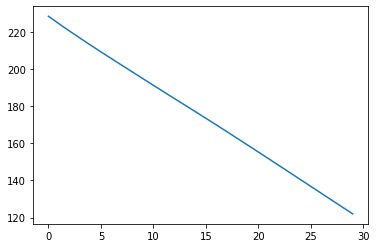

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

showPlot(cbow_losses, 'CBOW Losses')